# 18.1 보상을 최적화하기 위한 학습

* 강화 학습에서 소프트웨어 에이전트(Agent)는 관측(Observation)을 하고 주어진 환경(Environment)에서 행동(Action)을 한다. 그리고 그 결과로 보상(Reward)를 받는다.
 - 에이전트의 목적은 보상의 장기가간 기대치를 최대로 만드는 행동을 학습하는 것이다.
 - 즉, 에이전트는 환경 안에서 행동하고 시행착오를 겪으며, 기쁨이 최대가 되고, 아픔이 최소가 되도록 학습한다.

# 18.2 정책 탐색하기

* 소프트웨어 에이전트가 행동을 결정하기 위해 사용하는 알고리즘을 정책(Policy)이라고 한다.
 - 확률적 정책(Stochastic Policy) : 무작위성이 포함되어 있는 정책
* 예를 들어 어떤 확률 p로 회전 각도 r사이의 랜덤한 각도로 움직이는 로봇청소기의 강화 학습
 - 변경이 가능한 두 개의 정책 파라미터(Policy Parameter)가 있다.(확률 p / 각도 r)
 - 이 파라미터에 많은 다른 값을 시도해보고, 가장 성능이 좋은 조합을 고르는 학습 알고리즘을 정책 탐색(Policy Search)라고 한다.
 - 무작위로 찾는 방법은 정책 공간(Policy Space)가 매우 크면 비효율적이다.
* 정책 공간을 탐색하는 다른 방법으로 유전 알고리즘(Genetic Algorithm)이 있다.
* 또 다른 방법으로는 정책 파라미터에 대한 보상의 그레이디언트를 평가해서 높은 보상의 방향을 따르는 그레이디언트로 파라미터를 수정하는 정책을 그레이디언트(Policy Gradient, PG)라고 한다.

# 18.3 OpenAI 짐

* 강화 학습에서 어려운 점은 에이전트를 훈련하기 위해 먼저 작업 환경을 마련해야 한다는 것이다.
 - 현실적인 실험을 하기에는 제약이 많이 따른다.
 - 그래서 훈련을 위한 최소한의 시뮬레이션 환경이 필요하다.
 - PyBullet, MuJoCo 같은 3D 물리 시뮬레이션 라이브러리등이 있다.
* OpenAI 짐은 다양한 종류의 시뮬레이션 환경을 제공하는 툴킷이다.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Pac

In [2]:
import gym

In [3]:
gym.envs.registry.all()

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [4]:
env = gym.make('CartPole-v1')
obs = env.reset()
obs

array([-0.01489909,  0.03156273, -0.02484269,  0.00166785])

* CartPole
 - 카트 위에 놓인 막대가 넘어지지 않도록 왼쪽이나 오른쪽으로 가속할 수 있는 2D 시뮬레이션
 - 관측은 네 개의 실수를 담은 1D넘파이 배열
 - 카트의 수평위치 / 카트의 속도 / 막대의 각도 / 막대의 가속도

In [5]:
# 환경 출력
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()
except ImportError:
    pass

In [6]:
env.render()

True

In [7]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [8]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

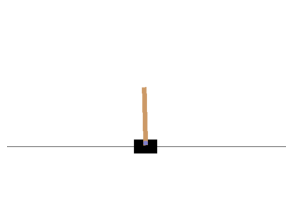

In [9]:
plot_environment(env)
plt.show()

In [10]:
#가능한 행동
env.action_space

Discrete(2)

In [11]:
action=0 #왼쪽으로 가속
obs, reward, done, info = env.step(action)
obs

array([-0.01426783, -0.1631943 , -0.02480933,  0.28641024])

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

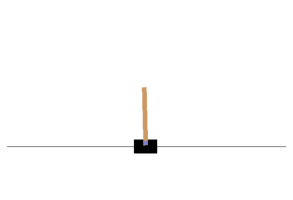

In [12]:
plot_environment(env)

 - obs : 새로운 관측값
 - reward : 이 환경에서는 어떤 행동을 실행해도 매 스텝마다 1.0의 보상을 받는다.
 - done : 이 값이 True면 에프소드가 끝남. 막대가 너무 기울어지거나 화면 밖으로 나가거나 200 스텝 이상이 지나면 에피소드가 끝난다. (에피소드가 끝나면 초기화 필요)
 - infop : 다른 환경에서는 이 딕셔너라에 디버깅이나 훈련에 유용한 추가적인 정보가 담길 수 있다.

In [13]:
#알아서 좌우로 가속하는 간단한 정책
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [14]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.044, 8.895508079924383, 25.0, 71.0)

In [15]:
frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [16]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [17]:
plot_animation(frames)

* 500번을 시도해도 이 정책은 막대를 쓰러뜨리지 않고 67번보다 많은 스텝을 진행하지 못한다.
* 그렇다면 신경망이 더 좋은 정책을 만들 수 있을까?

# 18.4 신경망 정책

* 앞서 하드코딩한 정책과 마찬가지로 이 신경망은 관측을 입력으로 받고 실행할 행동을 출력한다.
 - 각 행동에 대한 확률을 추정
 - 그리고 추정된 확률에 따라 랜덤하게 행동을 선택
* 가장 높은 점수의 행동을 그냥 선택하지 않고, 신경망이 만든 확률을 기반으로 랜덤하게 행동을 선택하는 이유
 - 에이전트가 새로운 행동을 탐험(Exploring)하는 것과 잘 할 수 있는 행동을 활용하는 것 사이에 균형을 맞추게 한다.

In [18]:
#keras를 사용한 신경망 정책
keras.backend.clear_session()
n_inputs = 4
model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid"),
])

* 근데 어떻게 훈련 시키지?

In [19]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [20]:
frames = render_policy_net(model)
plot_animation(frames)

# 18.5 행동 평가 : 신용 할당 문제

* 각 스텝에서 가장 좋은 행동이 무엇인지 알고 있다면 평소처럼 추정된 확률과 타깃 확률 사이의 크로스 엔트로피를 최소화하도록 신경망을 훈련할 수 있다.
* 하지만 강화 학습에서 에이전트가 얻을 수 있는 가이드는 보상뿐이다.
* 신용 할당 문제(Credit Assignment Problem) : 에이전트가 보상을 받았을 때 어떤 행동 덕분인지 알기 어려운 문제
 - 이를 해결하기 위해 흔히 사용하는 전략은 행동이 일어난 후 각 단계마다 할인 계수(Discount Factor, γ)를 적용한 보상을 모두 합하여 행동을 평가한다.
 - 할인된 보상의 합을 행동의 대가(Return)라고 부른다.
 - 평균적으로 다른 가능한 행동과 비교해서 각 행동이 얼마나 좋은지 혹은 나쁜지를 추정한 값을 행동 이익(Action Advantage)라고 부른다.

# 18.6 정책 그레이디언트

* PG알고리즘 : 높은 보상을 얻는 방향의 그레이디언트를 따르도록 정책의 파라미터를 최적화하는 알고리즘
* 그 중 1992년 로날드 윌리엄스가 소개한 PEINFORCE 알고리즘
 - 신경망 정책이 여러 번에 걸쳐 게임을 플레이하고 매 스텝마다 선택된 행동이 더 높은 가능성을 가지도록 만드는 그레이디언트를 계산한다.
 - 에피소드를 몇 번 실행한 다음, 각 행동의 이익을 계산한다.
 - 한 행동의 이익이 양수이면 이 행동이 좋은 것임을 의미하므로, 미래에 선택될 가능성이 높도록 앞서 계산한 그레이디언트를 적용한다. 그러나 행동 이익이 음수이면 이 행동이 나쁜 것임을 의미하므로 미래에 이 행동이 덜 선택되도록 반대의 그레이디언트를 적용한다. 이는 각 그레이디언트 벡터와 그에 상응하는 행동의 이익을 곱하면 된다.
 - 마지막으로 모든 결과 그레이디언트 벡터를 평균 내어 경사 하강법 스텝을 수행한다.

In [21]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

In [22]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [23]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [24]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [25]:
optimizer = keras.optimizers.Adam(lr=0.01)
loss_fn = keras.losses.binary_crossentropy

In [26]:
env = gym.make("CartPole-v1")

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 200.0

In [27]:
frames = render_policy_net(model)
plot_animation(frames)

# 18.7 마르코프 결정 과정

* 20세기 초 수학자 안드레이 마르코프가 메모리가 없는 확률 과정인 마르코프 연쇄(Markov Chain)에 대해 연구했다.
 - 이 과정은 정해진 개수의 상태를 가지고 있으며, 각 스텝마다 한 상태에서 다른 상태로 랜덤하게 전이된다.
 - 상태 s에서 상태 s'로 전이하기 위한 확률은 고정되어 있으며, 과거 상태에는 상관없이 (s, s')쌍에만 의존한다. 
* 마르코프 결정 과정은 1950년대 리처드 벨먼이 처음으로 논문에 기술했다.
 - 각 스텝에서 에이전트는 여러 가능한 행동 중 하나를 선택할 수 있고, 전이 확률은 선택된 행동에 따라 달라진다.
 - 어떤 상태 전이는 보상(음수 또는 양수)를 반환한다.
 - 에이전트의 목적은 시간이 지남에 따라 보상을 최대화하기 위한 정책을 갖는것이다.
* 벨먼은 어떤 상태 s의 최적의 상태 가치(State Value)를 추정하는 방법을 찾았다.
 - 이 값은 에이전트가 상태 s에 도달한 후 최적의 행동한다고 가정하고 평균적으로 기대할 수 있는 할인된 미래 보상의 합이다.
 - 에이전트가 최적으로 벨먼 최적 방정식이 적용된다는 것을 입증했다.
 - 즉, 에이전트가 최적으로 행동하면 현재 상태의 최적 가치는 하나의 최적 행동으로 인해 평균적으로 받게 될 보상과 이 행동이 유발할 수 있는 가능한 모든 다음 상태의 최적 가치의 기대치를 합한 것과 같다
* 벨먼의 최적 방정식
$$
V^*\left(s\right)=\max _a^{ }{\sum _s^{ }T\left(s,\ a,\ s'\right)\left[R\left(s,\ a,\ s'\right)+\gamma \cdot V^*\left(s'\right)\right]}
$$
 - T(s, a, s') : 에이전트가 행동 a를 선택했을 때 상태 s에서 s'로 전이될 확률
 - R(s, a, s') : 에이전트가 행동 a를 선택해서 상태 s에사 s'로 이동되었을 때 에이전트가 받을 수 있는 보상
 - $\gamma$ : 할인 계수
   - 알고리즘이 가능한 모든 상태에 대한 최적의 상태 가치를 정확히 추정할 수 있도록 도와준다.
   - 먼저 모든 상태 가치를 0으로 초기화한다.
   - 가치 반복(Value Iteration)알고리즘을 사용하여 반복적으로 업데이트 한다.
   - 충분한 시간이 주어지면 이 추정값이 최적의 정책에 대응되는 최적의 상태 가치에 수렴하는 것이 보장된다.
* 최적의 상태 가치를 아는 것은 정책을 평가할 때 유용하다.
 - 에이전트를 위한 최적의 정책을 알려주진 않는다.
 - 벨먼은 Q-가치(Q-Value)라고 부르는 최적의 상태-행동 가치(State-Action Value)를 추정할 수 있는 비슷한 알고리즘을 발견했다.
 - 상태 행동(s, a)쌍에 대한 최적의 Q-가치인 Q*(s, a)는 에이전트가 상태 s에 도달해서 행동 a를 선택한 후 이 행동의 결과를 얻기 전에 평균적으로 기대할 수 있는 할인된 미래 보상의 합이다.
 - 여기서는 에이전트가 이 행동 이후에 최적으로 행동할 것이라고 가정한다.
* Q-가치 반복 알고리즘이 작동하는 방식
 - Q-가치의 추정을 모두 0으로 초기화한다.
 - 그 다음에 Q-가치 반복 알고리즘을 사용해 업데이트한다.
 - 가치 반복 알고리즘
 $$
 Q_{k+1}\left(s,\ a\right)={\sum _s^{ }T\left(s,\ a,\ s'\right)\left[R\left(s,\ a,\ s'\right)+\gamma \cdot \max _{a'}^{ }{Q_k}\left(s',\ a'\right)\right]}
 $$
 - 최적의 Q-가치를 구하면 최적의 정책($\pi ^*$(s))을 정의하는 것은 간단하다.
 - 에이전트가 상태 s에 도달했을 때 가장 높은 Q-값을 가진 행동을 선택하면 된다.
 $$
 \pi ^*\left(s\right)=\arg \max _a^{ }Q^*{\left(s,\ a\right)}
 $$

In [28]:
#MDP 정의
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [29]:
#Q-가치 반복 알고리즘
Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

In [30]:
gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown

In [31]:
Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [32]:
np.argmax(Q_values, axis=1)

array([0, 0, 1])

# 18.8 시간차 학습

* 시간차 학습(Temporal differencec Learning, TD학습)은 가치 반복 알고리즘과 매우 비슷하지만, 에이전트가 MDP에 대해 일부 정보만 알고 있을 때를 다룰 수 있도록 변형한 것이다.
 - 일반적으로 에이전트가 초기에 가능한 상태와 행동만 알고 다른 것은 모른다고 가정한다.
 - 에이전트는 탐험 정책을 사용해 MDP를 탐험한다.
 - 탐험이 진행될수록 TD 학습 알고리즘이 실제로 관측된 전이와 보상에 근거하여 상태 가치의 추정값을 업데이트 한다.
* TD 학습 알고리즘
$$
V_{k+1}\left(s\right)\gets \left(1-\alpha \right)V_k\left(s\right)+\alpha \left(r+\gamma \cdot V_k\left(s'\right)\right)
$$
또는
$$
V_{k+1}\left(s\right)\gets V_k\left(s\right)+\alpha \cdot \delta _k\left(s,\ r,\ s'\right),\ \ \ \ \ \delta _k\left(s,\ r,\ s'\right)=r+\gamma \cdot V_k\left(s'\right)-V_k\left(s\right)
$$
 - $\alpha$는 학습률
 - $r+\gamma \cdot V_k\left(s'\right)$ 는 TD타깃
 -$\delta _k\left(s,\ r,\ s'\right)$는 TD오차
 - 각 상태 s에서 이 알고리즘은 에이전트가 이 상태를 떠났을 때 얻을 수 있는 당장의 보상과 나중에 기대할 수 있는 보상을 더한 이동 평균을 저장한다.

# 18.9 Q-러닝

* Q-러닝(Q-Learning) 알고리즘은 전이 확률과 보상을 초기에 알지 못한 상황에서 Q-가치 반복 알고리즘을 적용한 것
 - Q-러닝은 에이전트가 플레이 하는 것을 보고 점진적으로 Q-가치 추정을 향상하는 방식으로 작동한다. 
 - 정확한 Q-가치 추정을 얻게되면 최적의 정책은 가장 높은 Q-가치를 가지는 행동을 선택하는 것이다.(즉 탐욕적)
 - 각 상태-행동 (s,a) 쌍마다 이 알고리즘이 행동 a를 선택해 상태 s를 떠났을 때 에이전트가 받을 수 있는 보상 r과 기대할 수 있는 할인된 미래 보상의 합을 더한 이동 평균을 저장한다.
 - 미래 보상의 합을 추정하기 위해서는 타깃 정책이 이후로 최적으로 행동한다고 가정하고 다음 상태 s'에 대한 Q-가치 추정의 최댓값을 선택한다.

In [33]:
#Q-러닝 알고리즘
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [34]:
#에이전트의 탐색 정책
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [35]:
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = []

for iteration in range(10000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

In [36]:
Q_values

array([[18.80358909, 17.2965713 , 13.86052022],
       [ 0.        ,        -inf, -7.62349296],
       [       -inf, 49.43227644,        -inf]])

In [37]:
np.argmax(Q_values, axis=1) # optimal action for each state

array([0, 0, 1])

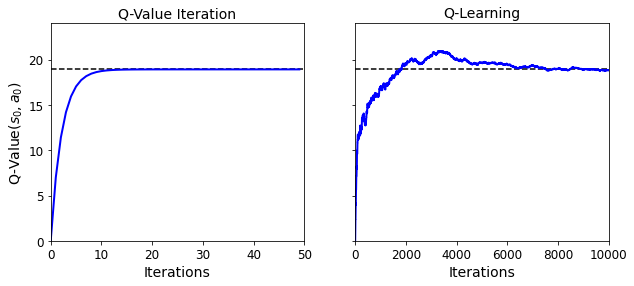

In [38]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

 - 훈련된 정책을 반드시 실행에 사용하지 않기 때문에 Q-러닝 알고리즘을 오프-폴리시(Off-Policy)알고리즘이라고 한다.
 - 정책 그레이디언트 알고리즘은 온-폴리시(On-Policy)알고리즘이라고 한다.

## 18.9.1 탐험 정책

* 완전한 랜덤 정책이 결국에는 모든 상태와 전이를 여러 번 경험한다고 보장하지만, 이렇게 하려면 극단적으로 오랜 시간이 걸릴 수 있다.
* 그러므로 더 나은 방법은 ε-그리디 정책(ε-greedy policy)을 사용하는 것이다.
 - 각 스텝에서 ε 확률로 랜덤하게 행동하거나 1-ε 확률로 그 순간 가장 최선인 것으로 행동한다.
 - ε-그리디 정책의 장점은 Q-가치 추정이 점점 더 향상되기 때문에 환경에서 관심 있는 부분을 살펴보는 데 점점 더 많은 시간을 사용한다는 점이다.
 - 그럼에도 여전히 MDP의 알려지지 않은 지역을 방문하는 데 일정 시간을 사용할 것이다.
 - ε의 값은 높게 시작해서 점점 감소되는 것이 일반적이다.
* 다른 방법으로는 탐험의 가능성에 의존하는 대신 이전에 많이 시도하지 않았던 행동을 시도하도록 탐험 정책을 강조하는 방법이 잇다.
 - 이런 방식은 Q-가치 추정에 보너스를 추가하는 방식으로 구현한다.

# 18.9.2 근사 Q-러닝과 심층 Q-러닝

* Q-러닝의 주요 문제는 많은 상태와 행동을 가진 대규모의 MDP에 적용하기 어렵다는 것이다.
* 해결책은 어떤 상태-행동 (s, a)쌍의 Q-가치를 근사하는 함수 $Q_{\theta}(s, a)를 적절한 개수의 파라미터를 사용하여 찾는 것. 이를 근사 Q-러닝(Approximate Q-Learning)이라고 한다.
* 심층 신경망을 사용해 특히 복잡한 문제에서 훨씬 더 나은 결과를 냈고, 어떤 특성 공학도 필요하지 않았다.
 - Q-가치를 추정하기 위해 사용하는 DNN을 심층 Q-네트워크(Deep-Q-Network, DQN)라고 하고, 근사 Q-러닝을 위해 DQN을 사용하는 것을 심층 Q-러닝(Deep-Q-Learning, DQL)이라고 한다. 
* DQN 훈련방법
 - 근사 Q-가치는 상태 s에서 행동 a를 실행했을 때 관측된 보상r과 그 이후에 최적으로 행동해서 얻은 할인된 가치를 더한 값에 가능한 한 가깝게 되어야 한다.
 - 미래의 할인된 가치를 추정하기 위해서는 간단하게 다음 상태 s'와 모든 가능한 행동 a'에 대해 DQN을 실행하면 모든 가능한 행동에 대한 미래의 근사 Q-가치를 얻을 수 있다.
 - 그 다음에 가장 높은 것을 고르고 할인을 적용하면 할인된 미래 보상의 추정을 얻을 수 있다.
 - 보상 r과 미래의 할인된 가치 추정을 더하면 상태-행동 쌍(s, a)에 대한 타깃 Q-가치 y(s, a)를 얻게 된다.
 - 이 타깃 Q-가치로 경사 하강법을 사용해 훈련 단계를 수행할 수 있다.

# 18.10 심층 Q-러닝 구현하기

In [39]:
env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

In [40]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [41]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [42]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [43]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [44]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [45]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [46]:
rewards = [] 
best_score = 0

In [47]:
for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step > best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 599, Steps: 13, eps: 0.010

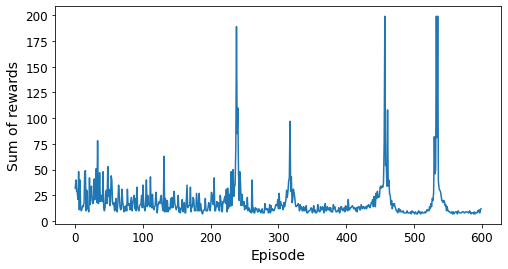

In [48]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [49]:
frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

ValueError: ignored

 - 에이전트가 환경을 탐색하면 정책을 업데이트한다.
 - 하지만 환경의 한 부분에서 학습한 것이 다른 부분에서 앞서 학습한 것을 망가뜨릴 수 있다.
 - 경험은 크게 연관되며 학습 환경은 계속 바뀐다.
 - 훈련은 종종 불안정하고 많은 하이퍼파라미터 값과 랜덤 시드를 시도해야 잘 작동하는 조합을 찾을 수 있다.

# 18.11 심층 Q-러닝의 변종

* 기본 심층 Q-러닝 알고리즘에서 모델은 예측을 만들고 타깃을 설정하는 데 모두 사용된다.
* 이런 피드백 순환 과정은 네트워크를 불안정하게 만들 수 있다.
 - 발산, 진동, 동결 등의 문제가 생긴다.
* 이 문제를 해결하기 위해 딥마인드 연구자들은 두 개의 DQN을 사용했다.
 - 첫 번째는 각 스텝에서 학습하고 에이전트를 움직이는 데 사용하는 온라인 모델
 - 두 번째는 타깃을 정의하기 위해서만 사용하는 타깃 모델이다.

In [52]:
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [53]:
next_Q_values = target.predict(next_states)

NameError: ignored

In [54]:
if episode % 50 == 0:
    target.set_weights(model.get_weights())

 - 타깃 모델이 온라인 모델보다 자주 업데이트되지 않으므로, Q-가치 타깃이 더 안정적이고 앞서 언급한 피드백 반복을 완화하고 이에 대한 영향이 감소한다.

# 18.11.2 더블 DQN

* 딥마인드 연구자들은 DQN 알고리즘을 개선하여 성능과 훈련의 안정성을 향상했다.
* 더블 DQN(Double DQN)
 - 타깃 네트워크가 Q-가치를 과대평가하기 쉽다는 관측을 기반으로 한다.
 - 다음 상태에서 최선의 행동을 선택할 때 타깃 모델 대신 온라인 모델을 사용하도록 제안
 - 타깃 모델은 최선의 행동에 대한 Q-가치를 추정할 때만 사용한다.


In [55]:
# 수정된 traing_step()
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    mask = tf.one_hot(actions, n_outputs)
# [..]

# 18.11.3 우선 순위 기반 경험 재생

In [56]:
K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)
state_values = keras.layers.Dense(1)(hidden2)
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [57]:
discount_rate = 0.95
optimizer = keras.optimizers.Adam(lr=1e-2)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [58]:
replay_memory = deque(maxlen=2000)

In [59]:
rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step > best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode > 50:
        training_step(batch_size)
    if episode % 200 == 0:
        target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 10, eps: 0.010

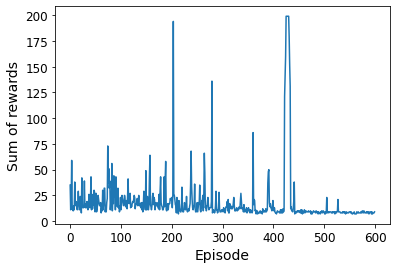

In [60]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [61]:
frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

ValueError: ignored

* 재생 버퍼에서 경험을 균일하게 샘플링하는 것이 아니라 중요한 경험을 더 자주 샘플링하는 아이디어
 - 중요도 샘플링(Importance Sampling, IS) 또는 우선 순위 기반 경험 재생(Prioritized Experience Replay, PER)이라고 한다.
 - TD 오차의 크기를 측정하여, 어떤 경험이 학습 진행을 빠르게 만들면 중요한 것을 찾는다.
 - 샘플이 중요한 경험에 편향되어 있으므로 훈련하는 동안 중요도에 따라 경험의 가중치를 낮춰서 이 편향을 보상해주어야 한다.

# 18.12 TF-Agents 라이브러리

* TF-Agents 라이브러리는 구글에서 개발하여 2018년에 오픈 소스로 공개한 텐서플로 기반의 강화 학습 라이브러리

## 18.12.1 TF-Agents 설치하기

In [ ]:
pip install tf-agents

In [ ]:
pip install 'gym[atari]'

## 18.12.2 TF-Agents 환경

In [ ]:
from tf_agents.environments import suite_gym

env = suite_gym.load("Breakout-v4")
env

In [ ]:
env.gym

In [ ]:
env.reset()

In [ ]:
env.step(1)

 - 관측과 부가 정보를 감싼 TimeStep객체를 반환한다.

In [ ]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")

plt.show()

In [ ]:
env.current_time_step()

## 18.12.3 환경 스펙

* TF-Agents는 관측, 행동, 타임 스텝의 크기, 데이터 타입, 이름과 최솟값, 최댓값을 포함하는 스펙(Specification)을 제공한다.

In [ ]:
env.observation_spec()

In [ ]:
env.action_spec()

In [ ]:
env.time_step_spec()

In [ ]:
env.gym.get_action_meanings()

## 18.12.4 환경 래퍼와 아타리 전처리



* TF-Agents는 tf_agents.environments.wrappers 패키지에 여러 가지 환경 래퍼를 제공한다.
 - 래퍼는 환경을 감싸고 있어 모든 호출을 환경으로 전달한다.
 - 추가적인 기능을 제공한다.


In [ ]:
import tf_agents.environments.wrappers

for name in dir(tf_agents.environments.wrappers):
    obj = getattr(tf_agents.environments.wrappers, name)
    if hasattr(obj, "__base__") and issubclass(obj, tf_agents.environments.wrappers.PyEnvironmentBaseWrapper):
        print("{:27s} {}".format(name, obj.__doc__.split("\n")[0]))

In [ ]:
from tf_agents.environments.wrappers import ActionRepeat

repeating_env = ActionRepeat(env, times=4)
repeating_env

In [ ]:
repeating_env.unwrapped

In [ ]:
from functools import partial
from gym.wrappers import TimeLimit

limited_repeating_env = suite_gym.load(
    "Breakout-v4",
    gym_env_wrappers=[partial(TimeLimit, max_episode_steps=10000)],
    env_wrappers=[partial(ActionRepeat, times=4)],
)

In [ ]:
limited_repeating_env

* 아타리 환경을 사용하는 경우 적용하는 표준적인 전처리 단계
 - 흑백 변환과 다운 샘플링 : 관측을 흑백으로 변환하고 다운샘플링한다.
 - 맥스 풀링 : 게임의 마지막 두 프레임을 1 X 1 필터로 맥스 풀링한다. 아타리 2600이 프레임에 출력할 수 있는 스프라이트 개수의 제한 때문에 나타날 수 있는 플리커 현상을 제거한다.
 - 프레임 스킵 : 에이전트는 4프레임마다 게임을 볼 수 있다. 그리고 건너뛴 프레임에 행동을 반복하여 보상을 누적한다. 에이전트 측면에서 게임의 속도를 높이고 보상 지연이 줄어들기 때문에 훈련속도도 빨라진다.
 - 죽었을 때 게임 종료 : 일부 게임에서는 보상이 점수만을 기반으로 하기 때문에 말이 죽었을 때 에이전트가 아무런 벌칙을 받지 않는다. 이를 해결하기 위한 한가지 방법으로 말이 죽었을때 게임을 종료한다.

In [ ]:
from tf_agents.environments import suite_atari
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

max_episode_steps = 27000 # <=> 108k ALE frames since 1 step = 4 frames
environment_name = "BreakoutNoFrameskip-v4"

env = suite_atari.load(
    environment_name,
    max_episode_steps=max_episode_steps,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [ ]:
env

In [ ]:
env.reset()
time_step = env.step(1) # FIRE
for _ in range(4):
    time_step = env.step(3) # LEFT

In [ ]:
import numpy as np
env.reset()
time_step = env.step(1) # FIRE
for _ in range(4):
    time_step = env.step(3) # LEFT

In [ ]:
plt.figure(figsize=(6, 6))
plot_observation(time_step.observation)
plt.show()

In [ ]:
#TFPyEnvironment안에 환경 감싸기
from tf_agents.environments.tf_py_environment import TFPyEnvironment

tf_env = TFPyEnvironment(env)

## 18.12.5 훈련구조

* TF-Agents 훈련 프로그램은 일반적으로 병렬로 실행되는 두 부분으로 나눈디ㅏ.
 - 왼쪽은 드라이버(Driver)는 수집 정책(Collect Policy)으로 행동을 선택하여 환경을 탐색하고 경로(Trajectory)를 모은다. 이 경로를 옵저버에서 보내어 재생 버퍼에 저장한다.
 - 오른쪽의 에이전트는 재생 버퍼에서 경로의 배치를 추출하여 수집 정책이 사용할 네트워크를 훈련한다.
 

## 18.12.6  심층 Q-네트워크 만들기

In [ ]:
from tf_agents.networks.q_network import QNetwork

preprocessing_layer = keras.layers.Lambda(
                          lambda obs: tf.cast(obs, np.float32) / 255.)
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]

q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params)

## 18.12.7 DQN 에이전트 만들기

In [ ]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

# see TF-agents issue #113
#optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0,
#                                     epsilon=0.00001, centered=True)

train_step = tf.Variable(0)
update_period = 4 # run a training step every 4 collect steps
optimizer = tf.compat.v1.train.RMSPropOptimizer(learning_rate=2.5e-4, decay=0.95, momentum=0.0,
                                     epsilon=0.00001, centered=True)
epsilon_fn = keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0, # initial ε
    decay_steps=250000 // update_period, # <=> 1,000,000 ALE frames
    end_learning_rate=0.01) # final ε
agent = DqnAgent(tf_env.time_step_spec(),
                 tf_env.action_spec(),
                 q_network=q_net,
                 optimizer=optimizer,
                 target_update_period=2000, # <=> 32,000 ALE frames
                 td_errors_loss_fn=keras.losses.Huber(reduction="none"),
                 gamma=0.99, # discount factor
                 train_step_counter=train_step,
                 epsilon_greedy=lambda: epsilon_fn(train_step))
agent.initialize()

## 18.12.8 재생 버퍼와 옵저버 만들기

In [ ]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=1000000)

replay_buffer_observer = replay_buffer.add_batch

In [ ]:
class ShowProgress:
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

## 18.12.9 훈련 측정 지표 만들기

In [ ]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]


In [ ]:
train_metrics[0].result()

In [ ]:
from tf_agents.eval.metric_utils import log_metrics
import logging
logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

## 18.12.10 수집 드라이버 만들기

* 드라이버는 주어진 정책으로 환경을 탐색하고 경험을 수집하고 옵저버에 이를 전파하는 객체로, 각 스텝에서 다음 작업을 수행한다.
 - 드라이버는 현재 타입 스텝을 수집 정책에 전달한다. 수집 정책은 타임 스텝을 사용해 행동을 선택하고 행동을 포함한 행동 스텝을 반환한다.
 - 그 다음 드라이버는 행동을 환경에 전달하고 다음 타임 스텝을 반환받는다.
 - 마지막으로 드라이버는 이 전이를 표현하는 경로 객체를 만들고 모든 옵저버에게 이를 전파한다.
* 배치 환경이 가능하다.
 - 드라이버가 배치 타임 스텝(Batcyed Time Step)을 정책에 전달한다.
 - 드라이버는 이전 정책 상태의 배치도 전달한다.
 - 정책은 행동의 배치와 정책 상태의 배치를 담은 배치 행동 스탭을 반환한다.
 - 마지막으로 드라이버는 배치 경로(Batched Trajectory)를 만든다.

In [ ]:
#주어진 스텝 횟수에 대한 경험을 수집
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period) # collect 4 steps for each training iteration

In [ ]:
#주어진 에피소드 횟수에 대한 경험을 수집
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(),
                                        tf_env.action_spec())
init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000) # <=> 80,000 ALE frames
final_time_step, final_policy_state = init_driver.run()

## 18.12.11 데이터셋 만들기

In [ ]:
trajectories, buffer_info = replay_buffer.get_next(
    sample_batch_size=2, num_steps=3)


In [ ]:
trajectories._fields

In [ ]:
trajectories.observation.shape

In [ ]:
from tf_agents.trajectories.trajectory import to_transition

time_steps, action_steps, next_time_steps = to_transition(trajectories)
time_steps.observation.shape

In [ ]:
trajectories.step_type.numpy()

In [ ]:
plt.figure(figsize=(10, 6.8))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row * 3 + col + 1)
        plot_observation(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig("sub_episodes_plot")
plt.show()

In [ ]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

## 18.12.12 훈련 반복 만들기

In [ ]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)

In [ ]:
def train_agent(n_iterations):
    time_step = None
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(
            iteration, train_loss.loss.numpy()), end="")
        if iteration % 1000 == 0:
            log_metrics(train_metrics)

In [ ]:
train_agent(n_iterations=10000)

In [ ]:
frames = []
def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

prev_lives = tf_env.pyenv.envs[0].ale.lives()
def reset_and_fire_on_life_lost(trajectory):
    global prev_lives
    lives = tf_env.pyenv.envs[0].ale.lives()
    if prev_lives != lives:
        tf_env.reset()
        tf_env.pyenv.envs[0].step(1)
        prev_lives = lives

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, reset_and_fire_on_life_lost, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()

plot_animation(frames)

In [ ]:
import PIL

image_path = os.path.join("images", "rl", "breakout.gif")
frame_images = [PIL.Image.fromarray(frame) for frame in frames[:150]]
frame_images[0].save(image_path, format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=30,
                     loop=0)

In [ ]:
%%html
<img src="images/rl/breakout.gif" />

# 18.13 그 외 유명한 강화 학습 알고리즘

* 액터-크리틱(Actor-Critic) 알고리즘
 - 정책 그레이디언트와 심층 Q-네트워크를 결합한 강화 알고리즘
 - 액터-크리틱 에이전트는 정책 네트워크와 DQN 네트워크 두 개를 포함한다.
 - DQN은 에이전트의 경험을 통해 보통과 같이 훈련된다.
 - 정책 네트워크는 일반적인 정책 그레이디언트와 다르게 훈련된다.
 - 여러 에피소드를 진행해서 각 행동의 가치를 추정하고 각 행동의 할인된 미래 보상을 합하여 정규화하는 대신 에이전트는 DQN이 추정한 행동 가치에 의존한다.
* A3C(Asynchronous Advantage Actor-Critic)
 - 복사된 다른 환경을 탐색하면서 병렬로 여러 에이전트가 학습하는 중요한 액터-크리틱 변종
 - 일정한 간격으로 비동기적으로 각 에이전트가 마스터 네트워크로 가중치 업데이트를 보낸다.
 - 그 다음 이 네트워크에서 최신의 가중치를 받아온다.
 - 각 에이전트는 마스터 네트워크의 향상에 기여하면서 다른 에이전트가 학습한 것에서 혜택을 받는다.
 - 또한 Q-가치를 추정하는 대신 안정적인 훈련을 위해 DQN이 각 행동의 이익을 추정한다.
* A2C(Advantage Actor-Critic)
 - 비동기성을 제거한 A3C알고리즘
 - 모든 모델이 동기적으로 업데이트된다.
 - 따라서 GPU의 성능을 십분 활용해 큰 배치에 대해 그레이디언트 업데이터를 수행할 수 있다.
* SAC(Soft Actor-Critic)
 - 보상뿐만 아니라 행동의 엔트로피를 최대화하도록 학습한다.
 - 가능한 많은 보상을 얻으려 하지만 가능한 예측이 어렵도록 만든다.
 - 환경을 탐색하여 훈련 속도를 높이고 DQN이 불완전한 추정을 만들 때 같은 행동을 반복해 실행하지 않도롣 돕는다.
* PPQ(Proximal Policy Optimization)
 - 큰 가중치 업데이트를 피하기 위해 손실 함수를 클리핑하는 A2C기반의 알고리즘
* 호기심 기반 탐색(Curiosity-based Exploration)
 - 강화 학습에서 보상의 희소성 문제가 계속 일어나는데, 이는 학습을 느리고 비효율적으로 만든다.
 - 보상이 환경에서 오는 것이 아니라 에이전트가 순수한 호기심만으로 환경을 탐색하게 만든다면?
 - 결과가 예측 가능하면 다른 곳으로 이동한다. 하지만 결과가 예측하지 못한 것이라면 에이전트가 이를 제어할 방법이 없다는 것을 안다.
 - 시간이 지나면 이것도 예측 가능해지고 지루해진다.